In [32]:
import pandas as pd
import datetime
from os import listdir
import os, os.path
from os.path import isfile, join
import numpy as np
import csv
import re
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.util import dataframe_utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, calinski_harabaz_score, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN, MeanShift, AffinityPropagation
%matplotlib inline

In [2]:
#add the data to notebook directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [3]:
#Data reading
df_prueba = pd.read_csv(parentdir+"\\Log of analysis of time aspects.csv",index_col=0)
df_prueba = df_prueba.rename(columns={"concept:name": "Operation", "Variant": "concept:name"})
df_prueba["Year"]=df_prueba["Year"].apply(str)
df_prueba['q-y'] = df_prueba['Question'] + '-' + df_prueba['Year']
df_prueba

df_prueba

,case:id,case:concept:name,Operation,concept:name,time:timestamp,Question,Report,Year,Category,Type,Tupla,Organization,q-y
0,A2 P4 BPI 2020,A2 P4 BPI 2020,Filter activities,Filter activities by sub-processes,2022-03-11 19:24:15.966942,P4,A2,2020,Student,Manipulation,A22020,"Faculty of Science, Utrecht University",P4-2020
1,A2 P4 BPI 2020,A2 P4 BPI 2020,Group activities,Group activities by sub-processes,2022-03-11 20:24:15.966942,P4,A2,2020,Student,Manipulation,A22020,"Faculty of Science, Utrecht University",P4-2020
2,A2 P4 BPI 2020,A2 P4 BPI 2020,Calculate cycle time,Calculate cycle time for all pairs of events f...,2022-03-11 21:24:15.966942,P4,A2,2020,Student,Analyze Time,A22020,"Faculty of Science, Utrecht University",P4-2020
3,A7 P4 BPI 2020,A7 P4 BPI 2020,Group activities,Group activities by role,2022-03-11 22:24:15.966942,P4,A7,2020,Academic,Manipulation,A72020,German Research Center for Artificial Intellig...,P4-2020
4,A7 P4 BPI 2020,A7 P4 BPI 2020,Calculate throughput,Calculate throughput,2022-03-11 23:24:15.966942,P4,A7,2020,Academic,Analyze Time,A72020,German Research Center for Artificial Intellig...,P4-2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,A19 P1-P2 BPI 2020,A19 P1-P2 BPI 2020,Group traces,Group traces by activities,2022-04-20 09:24:15.966942,P1-P2,A19,2020,Professional,Manipulation,A192020,Sberbank,P1-P2-2020
951,A19 P1-P2 BPI 2020,A19 P1-P2 BPI 2020,Calculate statistics,Calculate Statistics of activities,2022-04-20 10:24:15.966942,P1-P2,A19,2020,Professional,Calculate statistics,A192020,Sberbank,P1-P2-2020
952,A19 P1-P2 BPI 2020,A19 P1-P2 BPI 2020,Calculate throughput,Calculate throughput,2022-04-20 11:24:15.966942,P1-P2,A19,2020,Professional,Analyze Time,A192020,Sberbank,P1-P2-2020
953,A19 P1-P2 BPI 2020,A19 P1-P2 BPI 2020,Represent temporal series,Represent temporal series of throughput,2022-04-20 12:24:15.966942,P1-P2,A19,2020,Professional,Representation,A192020,Sberbank,P1-P2-2020


#### Similarity between answers and questions

In [10]:
df_report_year = df_prueba.groupby(by=['Question', 'Year'])
for name, group in df_report_year:
    operations = group['concept:name'].to_list()
    df_analisis = df_prueba.groupby(by=['case:concept:name'])
df_agrupado = pd.DataFrame(columns=['case:concept:name','Operations','Organization', 'Year', 'Question'])
for name, group in df_analisis:
    org = group.iloc[0]['Organization']
    year = group.iloc[0]['Year']
    question = group.iloc[0]['Question']
    lista = group['concept:name'].to_list()
        
    new_row={'case:concept:name':name, 'Operations':lista, 'Organization':org, 'Year':year, 'Question':question} 
    df_agrupado = df_agrupado.append(new_row, ignore_index=True)
    
df_agrupado

,case:concept:name,Operations,Organization,Year,Question
0,A1 P1 BPI 2017,[Calculate cycle time of the whole process for...,University of Liechtenstein\r\nVienna Universi...,2017,P1
1,A1 P1-P2 BPI 2020,"[Filter traces by activities, Calculate cycle ...","Technische Universität, Berlin",2020,P1-P2
2,A1 P2 BPI 2019,"[Group events by time, Calculate cycle time of...",University of Melbourne,2019,P2
3,A1 P5 BPI 2015,[Calculate cycle time of the whole process for...,Meijer & Van der Ham Management Consultants,2015,P5
4,A1 P5 BPI 2020,"[Filter traces by activities, Calculate cycle ...","Technische Universität, Berlin",2020,P5
...,...,...,...,...,...
105,A8 P1 BPI 2017,"[Filter traces by activities, Calculate waitin...",Universidade Federal do Estado do Rio de Janeiro,2017,P1
106,A8 P5 BPI 2015,[Calculate cycle time of the whole process for...,GRADIENT ECM,2015,P5
107,A9 P1 BPI 2017,"[Calculate processing time, Calculate waiting ...",POSTECH,2017,P1
108,A9 P2 BPI 2019,"[Filter traces by year, Calculate cycle time o...",KPMG Netherlands,2019,P2


In [12]:
def sorensenIndex(list1,list2):
    set1=set(list1)
    set2=set(list2)
    intersection = set1.intersection(set2)
    len1=len(list(set1))
    len2=len(list(set2))
    sorensenIndex=float(2*len(list(intersection)))/(len1+len2)
    return sorensenIndex

In [16]:
# similarity between pairs of answers
df2 = df_agrupado
df2 = df2.rename(columns={"Operations":"concept:name"})
columns=['analisis','question', 'sorensen']
df_metricas_preguntas = pd.DataFrame(columns=columns)

for i in range(len(df2)):       
    for j in range(i+1,len(df2)):
        grupo = df2.iloc[i]['concept:name']
        analisis = df2.iloc[i]['case:concept:name'] + "-" + df2.iloc[j]['case:concept:name']
        question = df2.iloc[i]['Question'] + df2.iloc[i]['Year'] +"-"+ df2.iloc[j]['Question'] + df2.iloc[j]['Year']
        sorensen = sorensenIndex(grupo,df2.iloc[j]['concept:name'])
        new_row={'analisis':analisis, 'question':question,'sorensen':sorensen} 
        df_metricas_preguntas = df_metricas_preguntas.append(new_row, ignore_index=True)
df_metricas_preguntas

,analisis,question,sorensen
0,A1 P1 BPI 2017-A1 P1-P2 BPI 2020,P12017-P1-P22020,0.000000
1,A1 P1 BPI 2017-A1 P2 BPI 2019,P12017-P22019,0.000000
2,A1 P1 BPI 2017-A1 P5 BPI 2015,P12017-P52015,0.095238
3,A1 P1 BPI 2017-A1 P5 BPI 2020,P12017-P52020,0.000000
4,A1 P1 BPI 2017-A1 P6 BPI 2020,P12017-P62020,0.166667
...,...,...,...
5990,A8 P5 BPI 2015-A9 P2 BPI 2019,P52015-P22019,0.190476
5991,A8 P5 BPI 2015-A9 P5 BPI 2015,P52015-P52015,0.454545
5992,A9 P1 BPI 2017-A9 P2 BPI 2019,P12017-P22019,0.000000
5993,A9 P1 BPI 2017-A9 P5 BPI 2015,P12017-P52015,0.000000


In [20]:
#average similarity between pairs of answers
df_metricas_preguntas = df_metricas_preguntas.replace({'P62020-P52015':'P52015-P62020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P52020-P52015':'P52015-P52020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P42020-P52015':'P52015-P42020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P1-P22020-P52015':'P52015-P1-P22020'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P62020-P12017':'P12017-P62020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P52020-P12017':'P12017-P52020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P42020-P12017':'P12017-P42020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P1-P22020-P12017':'P12017-P1-P22020'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P62020-P22019':'P22019-P62020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P52020-P22019':'P22019-P52020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P42020-P22019':'P22019-P42020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P1-P22020-P22019':'P22019-P1-P22020'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P12017-P52015':'P52015-P12017'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P22019-P52015':'P52015-P22019'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P22019-P12017':'P12017-P22019'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P62020-P1-P22020':'P1-P22020-P62020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P52020-P1-P22020':'P1-P22020-P52020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P42020-P1-P22020':'P1-P22020-P42020'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P62020-P42020':'P42020-P62020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P52020-P42020':'P42020-P52020'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P62020-P52020':'P52020-P62020'})
df_metricas_preguntas.describe()

,sorensen
count,5995.000000
mean,0.108498
std,0.149507
min,0.000000
25%,0.000000
50%,0.000000
75%,0.200000
max,1.000000


In [21]:
#average similarity between pairs of questions
df_metricas_preguntas.groupby(['question']).mean() 

,sorensen
question,
P1-P22020-P1-P22020,0.191182
P1-P22020-P42020,0.065174
P1-P22020-P52020,0.063244
P1-P22020-P62020,0.046785
P12017-P1-P22020,0.087856
P12017-P12017,0.216094
P12017-P22019,0.112189
P12017-P42020,0.065072
P12017-P52020,0.127760


In [23]:
#variance of similarity between pairs of questions
df_metricas_preguntas.groupby(['question']).var(ddof=0)

C:\Users\maria\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  


,sorensen
question,
P1-P22020-P1-P22020,0.027690
P1-P22020-P42020,0.012746
P1-P22020-P52020,0.012062
P1-P22020-P62020,0.010386
P12017-P1-P22020,0.012881
P12017-P12017,0.020089
P12017-P22019,0.013234
P12017-P42020,0.010446
P12017-P52020,0.017891


In [28]:
#variance of similarity between pairs of questions
df_metricas_preguntas.groupby(['question']).std(ddof=0)

,sorensen
question,
P1-P22020-P1-P22020,0.166403
P1-P22020-P42020,0.112897
P1-P22020-P52020,0.109827
P1-P22020-P62020,0.101913
P12017-P1-P22020,0.113493
P12017-P12017,0.141736
P12017-P22019,0.115041
P12017-P42020,0.102205
P12017-P52020,0.133757


#### Common variants between questions

In [29]:
#case frequency of variants per question 
#variants that exceed the average case frequency per question 
tabla = pd.DataFrame(columns=['C15', 'C17', 'C19', 'C20A', 'C20B', 'C20C', 'C20D'])
df3 = df_prueba.groupby(['q-y'])
for name, group in df3:
    tam=len(group['case:id'].unique())
    print(name, group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x)).mean())
    print(group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x)).head(30))
    mean = group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x)).mean()
    if(name == "P5-2015"):
        opu_P52015 = group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x))[group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x))>mean]
        for i in range(len(opu_P52015.index)):
            fila = opu_P52015.index[i]
            tabla.at[fila,'C15'] = (opu_P52015[i]*100/tam)
    elif(name == 'P1-2017'):
        opu_P12017 = group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x))[group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x))>mean]
        for i in range(len(opu_P12017.index)):
            fila = opu_P12017.index[i]
            tabla.at[fila,'C17'] = (opu_P12017[i]*100/tam)
    elif(name == 'P2-2019'):
        opu_P22019 = group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x))[group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x))>mean]
        for i in range(len(opu_P22019.index)):
            fila = opu_P22019.index[i]
            tabla.at[fila,'C19'] = (opu_P22019[i]*100/tam)
    elif(name == 'P1-P2-2020'):
        opu_P1_P222020 = group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x))[group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x))>mean]
        for i in range(len(opu_P1_P222020.index)):
            fila = opu_P1_P222020.index[i]
            tabla.at[fila,'C20A'] = (opu_P1_P222020[i]*100/tam)
    elif(name == 'P4-2020'):
        opu_P42020 = group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x))[group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x))>mean]
        for i in range(len(opu_P42020.index)):
            fila = opu_P42020.index[i]
            tabla.at[fila,'C20B'] = (opu_P42020[i]*100/tam)
    elif(name == 'P5-2020'):
        opu_P52020 = group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x))[group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x))>mean]
        for i in range(len(opu_P52020.index)):
            fila = opu_P52020.index[i]
            tabla.at[fila,'C20C'] = (opu_P52020[i]*100/tam)
    elif(name == 'P6-2020'):
        opu_P62020 = group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x))[group.groupby('Variant')['case:id'].agg(['unique'])['unique'].apply(lambda x: len(x))>mean]
        for i in range(len(opu_P62020.index)):
            fila = opu_P62020.index[i]
            tabla.at[fila,'C20D'] = (opu_P62020[i]*100/tam)

P1-2017 2.5
Variant
Assign resource to each activity                                                       1
Calculate Statistics of attributes                                                     1
Calculate cycle time for all pairs of events for a subset of traces                    2
Calculate cycle time for all pairs of events for all traces                            1
Calculate cycle time for all pairs of events for each subset of traces                 1
Calculate cycle time of a fragment of the process for a subset of traces               2
Calculate cycle time of a fragment of the process for all traces                       2
Calculate cycle time of a fragment of the process for each subset of traces            2
Calculate cycle time of only a subset of pairs of events for a subset of traces        2
Calculate cycle time of only a subset of pairs of events for all traces                4
Calculate cycle time of only a subset of pairs of events for each subset of traces     1
C

In [30]:
#common variants between questions and percentage of the answesrs in which they are used
tabla

,C15,C17,C19,C20A,C20B,C20C,C20D
Calculate cycle time of only a subset of pairs of events for all traces,NaN,19.047619,NaN,NaN,NaN,NaN,NaN
Calculate cycle time of the whole process for all traces,44.444444,28.571429,NaN,25.0,NaN,NaN,NaN
Calculate cycle time of the whole process for each subset of traces,55.555556,14.285714,33.333333,15.0,NaN,NaN,NaN
Calculate number of traces,22.222222,28.571429,41.666667,45.0,NaN,NaN,NaN
Calculate percentage of traces,NaN,23.809524,33.333333,25.0,17.647059,16.666667,NaN
Calculate processing time,NaN,23.809524,NaN,NaN,NaN,NaN,NaN
Calculate waiting time,NaN,66.666667,NaN,NaN,NaN,NaN,NaN
Filter events by attributes,NaN,14.285714,NaN,NaN,NaN,NaN,NaN
Filter traces by activities,22.222222,28.571429,58.333333,45.0,17.647059,22.222222,15.384615
Filter traces by attributes,NaN,14.285714,33.333333,NaN,NaN,NaN,NaN


#### Log clustering

In [37]:
#data reading
df_logs = pd.read_csv(parentdir+"\\log_metrics.csv",index_col=0)  
df_logs

,Eventos,Atributos,Trazas,Actividades,"N, communities",Cut vertex,Max cut vertex,Node similarity,"N, variants",Average trace length,...,gst,gcn,N,gcv,gsepr,gseqr,cf,std,tentr,prentr
Column1,,,,,,,,,,,,,,,,,,,,,
Log 1 - 2015,52217,29,1199,398,13,2,17,0.212553,1170,43.550459,...,0.970335,4302,398,6,0.015075,0.003831,1476.494306,0.890577,10.163379,14.346404
Log 2 - 2015,44354,28,832,410,14,8,17,0.194381,828,53.310096,...,0.971434,4393,410,8,0.019512,0.002707,1709.524590,0.869975,9.690824,14.528841
Log 3 - 2015,59681,29,1409,383,6,3,8,0.209645,1349,42.356991,...,0.966535,4527,383,4,0.010444,0.001630,1405.340194,0.889407,10.316860,14.265077
Log 4 - 2015,47293,29,1053,356,11,11,26,0.197169,1049,44.912631,...,0.971871,3210,356,7,0.019663,0.006732,1433.689474,0.873841,10.031975,14.065999
Log 5 - 2015,59083,29,1156,389,11,0,0,0.193965,1153,51.109862,...,0.967671,4504,389,0,0.000000,0.002453,1696.573501,0.868612,10.169735,14.451359
Log - 2017,1202267,19,31509,26,4,0,0,0.073718,15930,38.156305,...,0.736686,153,26,0,0.000000,0.000000,1222.111931,-0.467550,11.993121,14.422804
Log - 2019,1595923,21,251734,42,4,0,0,0.059524,11973,6.339720,...,0.717687,457,42,0,0.000000,0.002008,335.158316,0.849054,6.242550,15.877226
Log 1 - 2020,56437,10,10500,17,3,2,10,0.643137,99,5.374952,...,0.865052,23,17,2,0.117647,0.000000,63.139935,0.683826,2.597705,7.473676
Log 2 - 2020,72151,23,6449,34,3,0,0,0.378676,753,11.187936,...,0.830450,163,34,0,0.000000,0.000000,236.323372,0.670943,6.141601,10.625611


In [35]:
def muestra_agrupacion(puntos, clusters):
    puntos_2D = pd.DataFrame(PCA(n_components=2).fit_transform(puntos), columns=['x', 'y'])
    puntos_2D['grupo'] = clusters
    numero_grupos = len(pd.Series(clusters).unique())
    
    plt.figure(figsize=(5,5))
    paleta = sns.color_palette("bright", numero_grupos)
    sns.scatterplot(x='x', y='y', hue='grupo', data=puntos_2D, palette=paleta)
    plt.xticks([], [])
    plt.xlabel('')
    plt.yticks([], [])
    plt.ylabel('')
    plt.show()

          SILHOUETTE
KMEANS-2    0.928851
KMEANS-3    0.816436
KMEANS-4    0.299015
KMEANS-5    0.376258
KMEANS-6    0.281563
2 CLUSTERS


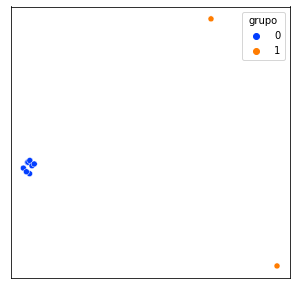

Cluster 0
Log 1 - 2015
Log 2 - 2015
Log 3 - 2015
Log 4 - 2015
Log 5 - 2015
Log 1 - 2020
Log 2 - 2020
Log 3 - 2020
Log 4 - 2020
Log 5 - 2020

Cluster 1
Log - 2017
Log - 2019

3 CLUSTERS


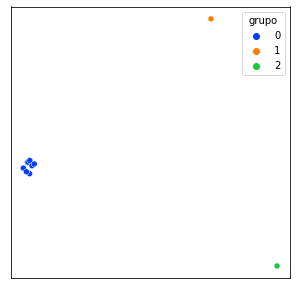

Cluster 0
Log 1 - 2015
Log 2 - 2015
Log 3 - 2015
Log 4 - 2015
Log 5 - 2015
Log 1 - 2020
Log 2 - 2020
Log 3 - 2020
Log 4 - 2020
Log 5 - 2020

Cluster 1
Log - 2017

Cluster 2
Log - 2019



In [36]:
#log clustering using Kmeans and the average of Silhouette Width to evaluate the clusters
METRICAS = pd.DataFrame(columns=['SILHOUETTE'])

df = df_logs
kmeans2 = KMeans(n_clusters=2, random_state=0).fit(df)
METRICAS.loc['KMEANS-2'] = (silhouette_score(df, kmeans2.labels_))

kmeans3 = KMeans(n_clusters=3, random_state=0).fit(df)
METRICAS.loc['KMEANS-3'] = (silhouette_score(df, kmeans3.labels_))

kmeans4 = KMeans(n_clusters=4, random_state=0).fit(df)
METRICAS.loc['KMEANS-4'] = (silhouette_score(df, kmeans4.labels_))

kmeans5 = KMeans(n_clusters=5, random_state=0).fit(df)
METRICAS.loc['KMEANS-5'] = (silhouette_score(df, kmeans5.labels_))

kmeans6 = KMeans(n_clusters=6, random_state=0).fit(df)
METRICAS.loc['KMEANS-6'] = (silhouette_score(df, kmeans6.labels_))

print(METRICAS)

print('2 CLUSTERS')
muestra_agrupacion(df, kmeans2.labels_)

for n in range(kmeans2.n_clusters):
    print('Cluster' ,  n) 
    for s in range(len(df)):
        if (kmeans2.labels_[s] == n):
            print(df.index[s])
    print("")
    
print('3 CLUSTERS')
muestra_agrupacion(df, kmeans3.labels_)

for n in range(kmeans3.n_clusters):
    print('Cluster' ,  n) 
    for s in range(len(df)):
        if (kmeans3.labels_[s] == n):
            print(df.index[s])
    print("")
    